In [1]:
# start coding here

In [1]:
import logomaker
import torch
import re, os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import textwrap

from Bio import motifs
from functools import partial
from glob import glob
from pyjaspar import jaspardb
from sklearn.metrics import precision_recall_fscore_support as score
from tqdm import tqdm
from matplotlib import gridspec
from pybedtools import BedTool
from gprofiler import GProfiler

In [2]:
import matplotlib.style as mplstyle
mplstyle.use('fast')
import matplotlib
matplotlib.rc('pdf', fonttype=42)
from fastcluster import linkage
from scipy.spatial import distance
from scipy.spatial.distance import pdist
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import fcluster, leaves_list
from scipy.stats import zscore
from collections import defaultdict
from sklearn.cluster import AgglomerativeClustering
#from cuml.cluster import AgglomerativeClustering 

In [3]:
rng = np.random.default_rng(1)

In [4]:
def compute_tcav(cav, attr):

    tcav = torch.matmul(torch.flatten(attr, start_dim=1), cav.T)
    print(cav.shape, attr.shape)
    tcav_score = ((tcav>0)*1.).mean(axis=0).cpu().numpy()

    return tcav, tcav_score

In [48]:
# parameters
cav_root_dir = "./cavs_test/cavs/"

attrs = "./cavs_test/test.attributions.pt"

activations_projected = "./cavs_test/test.activations_projected.pt"
activations_residual = "./cavs_test/test.activations_residual.pt"

regions = "./cavs_test/test.regions.bed"

output_dir = "./cavs_test/tcav_report/"

fscore_threshold:float = 0.95

In [59]:
cav_dirs = {i: os.path.join(cav_root_dir, i) for i in os.listdir(cav_root_dir)}

In [60]:
cav_dirs

{'AC0001:GATA-PROP:GATA_control_random_regions': './cavs_test/cavs/AC0001:GATA-PROP:GATA_control_random_regions',
 'AC0002:PROP-ALX:Homeodomain_control_random_regions': './cavs_test/cavs/AC0002:PROP-ALX:Homeodomain_control_random_regions',
 'AC0003:HNF1A-HNF1B:Homeodomain_control_random_regions': './cavs_test/cavs/AC0003:HNF1A-HNF1B:Homeodomain_control_random_regions',
 'AC0004:ZSCAN:C2H2_ZF_control_random_regions': './cavs_test/cavs/AC0004:ZSCAN:C2H2_ZF_control_random_regions',
 'AC0005:POU3F-POU1F:Homeodomain,POU_control_random_regions': './cavs_test/cavs/AC0005:POU3F-POU1F:Homeodomain,POU_control_random_regions'}

In [51]:
if regions is not None:
    regions = np.loadtxt(regions, dtype=str)

In [52]:
avs_projected = torch.load(activations_projected, map_location='cpu')
avs_residual = torch.load(activations_residual, map_location='cpu')

/tmp/ipykernel_2367435/806406243.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  avs_projected = torch.load(activations_projected, map_location='cpu')
/tmp/ipykernel_236

In [53]:
if avs_projected is not None:
    activations = torch.concat([avs_projected, avs_residual], dim=1)
else:
    activations = avs_residual

In [54]:
os.makedirs(output_dir)

In [55]:
attrs = torch.load(attrs)

/tmp/ipykernel_2367435/777408744.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  attrs = torch.load(attrs)


In [61]:
tcav_expts = []
for cn, cav_dir in cav_dirs.items():
    concept, control = cn.split("_control_")
    tcav_expts.append((re.sub(r'control_rep[0-9]_insert_', '', concept), control, cav_dir))
tcav_expts = pd.DataFrame(tcav_expts, columns=['concept', 'rep', 'cav_dir'])

In [62]:
tcav_expts

,concept,rep,cav_dir
0,AC0001:GATA-PROP:GATA,random_regions,./cavs_test/cavs/AC0001:GATA-PROP:GATA_control...
1,AC0002:PROP-ALX:Homeodomain,random_regions,./cavs_test/cavs/AC0002:PROP-ALX:Homeodomain_c...
2,AC0003:HNF1A-HNF1B:Homeodomain,random_regions,./cavs_test/cavs/AC0003:HNF1A-HNF1B:Homeodomai...
3,AC0004:ZSCAN:C2H2_ZF,random_regions,./cavs_test/cavs/AC0004:ZSCAN:C2H2_ZF_control_...
4,"AC0005:POU3F-POU1F:Homeodomain,POU",random_regions,./cavs_test/cavs/AC0005:POU3F-POU1F:Homeodomai...


In [66]:
dfs = []
cavs = defaultdict(list)
tcavs = defaultdict(list)

fscores = []
for item in tqdm(tcav_expts.itertuples()):

    prefix_dir = item.cav_dir
    
    perform = pd.read_table(f"{prefix_dir}/classifier_perform_on_test.txt", 
                            comment="#")

    precision, recall, fscore, support = score(perform.Truth, perform.Pred)

    fscores.append(np.mean(fscore))

    # here predictions are model outputs, so it's usually expected that concepts 0 has a higher probability of being bound
    #model_predictions_0 = np.loadtxt(f"{prefix_dir}/predictions_concept_0.txt")
    #model_predictions_1 = np.loadtxt(f"{prefix_dir}/predictions_concept_1.txt")
    
    classifier_scores = pd.DataFrame({'precision': precision,
                  'recall': recall,
                  'fscore': fscore,
                  'support': support})

    cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()
    tcav, tcav_score = compute_tcav(cav, attrs)
    cavs[item.concept].append(cav)
    tcavs[item.concept].append(tcav)

    dfs.append((np.mean(fscore), support, np.median(tcav.numpy(), axis=0)[0], tcav_score[0], tcav_score[1], item.concept, item.rep))

    # dfs.append((fscore[0], support, tcav_score[0], np.median(tcav.numpy(), axis=0)[0], 
    #             cav, tcav,
    #             #model_predictions_0.mean(), 
    #             item.concept, item.rep, item.layer, 0))
    # dfs.append((fscore[1], support, tcav_score[1], np.median(tcav.numpy(), axis=0)[1],
    #             cav, tcav,
    #             #model_predictions_1.mean(), 
    #             item.concept, item.rep, item.layer, 1))
    
# dfs_merge = pd.DataFrame(dfs, columns=['fscore', 'support', 'tcav_score', 'tcav_median', 
#                                        "cav", "tcav",
#                                        #'model_preds',
#                                        'concept', 'rep', 'layer', 'concept_id'])
dfs_merge = pd.DataFrame(dfs, columns=['fscore', 'support', 'tcav_score_median_test', 'tcav_pos_ratio_test', 'tcav_pos_ratio_control', 
                                       'concept', 'rep'])

#dfs_merge['concept_name'] = dfs_merge.apply(lambda x: f'Random genome with\n{x["concept"]} inserted' if x['concept_id']==0 else 'Random genome', axis=1)

0it [00:00, ?it/s]/tmp/ipykernel_2367435/1255733344.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cav = torch.load(f"{prefix_dir}/classifier_weights.pt").detach()
/tm

torch.Size([2, 188]) torch.Size([1000, 188])
torch.Size([2, 188]) torch.Size([1000, 188])
torch.Size([2, 188]) torch.Size([1000, 188])
torch.Size([2, 188]) torch.Size([1000, 188])
torch.Size([2, 188]) torch.Size([1000, 188])


760it [00:02, 260.22it/s]

787it [00:02, 261.06it/s]

815it [00:03, 265.68it/s]

846it [00:03, 275.63it/s]

860it [00:03, 272.85it/s]

<Axes: ylabel='Count'>

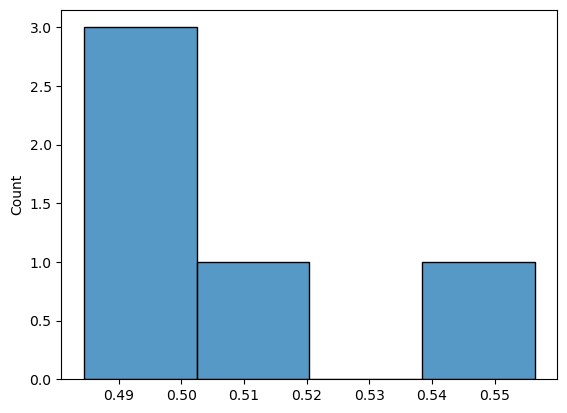

In [67]:
sns.histplot(x=fscores)

In [68]:
dfs_merge
dfs_merge.to_csv(f"{output_dir}/tcav_all_concepts.tsv")

In [69]:
dfs_merge = dfs_merge.loc[dfs_merge.fscore>fscore_threshold]
dfs_merge

,fscore,support,tcav_score_median_test,tcav_pos_ratio_test,tcav_pos_ratio_control,concept,rep
2,0.514597,"[461, 439]",1.188891,1.0,0.0,AC0003:HNF1A-HNF1B:Homeodomain,random_regions
3,0.556389,"[461, 434]",0.294493,1.0,0.0,AC0004:ZSCAN:C2H2_ZF,random_regions


In [72]:
motif_clustering_pwms = motifs.parse(open('data/motif-clustering-v2.1beta_consensus_pwms.meme'), fmt='MINIMAL')
motif_clustering_pwms = {m.name.replace('/', '-'): m.pwm for m in motif_clustering_pwms}

if len(dfs_merge) > 0:
    dfs_merge['motif_cluster'] = dfs_merge.concept.apply(lambda x: x if x.startswith('AC') else None).str.replace(r'_rep[0-9]', '', regex=True)

### Log ratio

In [73]:
def log_ratio(x):
    # the upper and lower bound should be ~5
    return np.log((x['tcav_pos_ratio_test']+0.01)/(x['tcav_pos_ratio_control']+0.01))
    
if len(dfs_merge) > 0:
    dfs_merge['log_ratio'] = dfs_merge.apply(log_ratio, axis=1)

### CAV correlation

In [76]:
motif_clustering_pwms = motifs.parse(open('data/motif-clustering-v2.1beta_consensus_pwms.meme'), fmt='MINIMAL')
motif_clustering_pwms = {re.findall(r'AC[0-9]*', m.name)[0]: m.pwm for m in motif_clustering_pwms} # index pwm by AC id
def seq_logo(cav_key, ax=None, max_len=20):
    ac_id = re.findall('AC[0-9]*', cav_key)
    if len(ac_id) == 1:
        pwm = motif_clustering_pwms.get(ac_id[0])
    
        pwm_df = pd.DataFrame(pwm)
        motif_len = len(pwm_df)
        
        # Logomaker expects columns as A,C,G,T, so ensure correct order
        pwm_df = pwm_df[['A', 'C', 'G', 'T']]
    
        # Compute information content at each position (2 - entropy)
        def compute_ic(pwm_row):
            entropy = -sum([p * np.log2(p) if p > 0 else 0 for p in pwm_row])
            return 2 - entropy
        
        # Compute IC matrix: IC_letter = p * IC_total
        ic_df = pwm_df.copy()
        for i in range(len(pwm_df)):
            ic_total = compute_ic(pwm_df.iloc[i])
            ic_df.iloc[i] = pwm_df.iloc[i] * ic_total
    
        
        # Plot with logomaker
        x0, y0, width, height = ax.get_position().bounds
        ax.set_position([x0, y0, width * min(1., motif_len/max_len), height])
        logo = logomaker.Logo(ic_df, color_scheme={'A': 'red', 'C': 'blue',
                                                  'G': 'orange', 'T': 'green'},
                              ax=ax)
        logo.ax.axis('off')
    else:
        ax.axis('off')


<Figure size 1300x800 with 0 Axes>

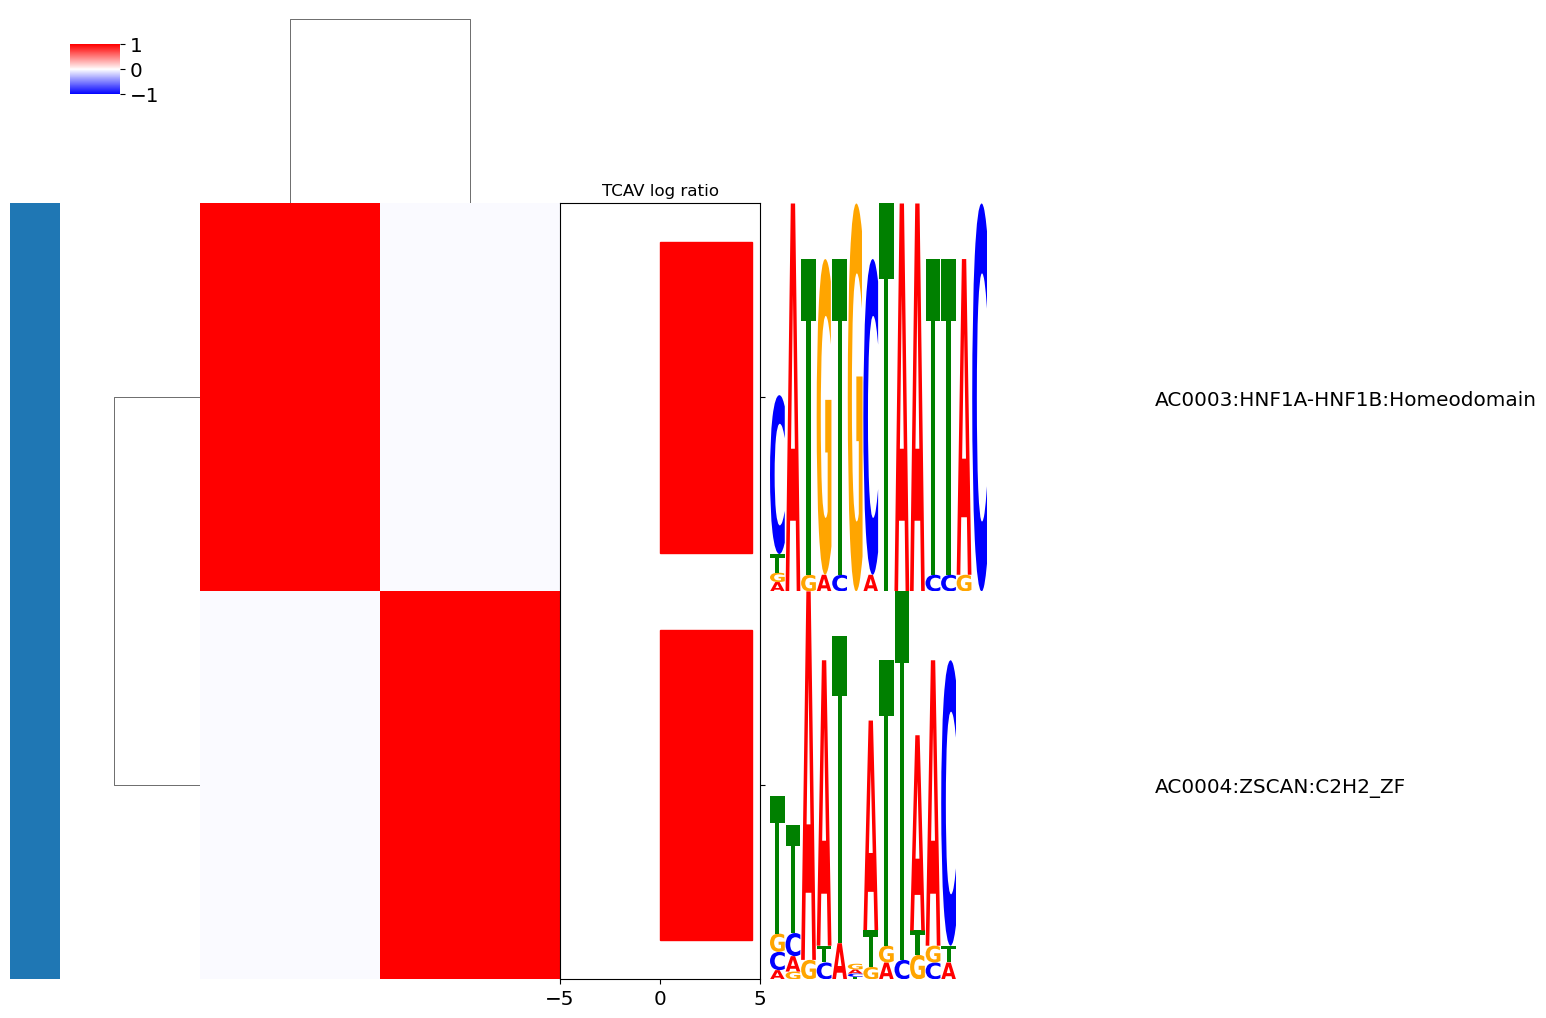

In [81]:
clustermap_width = 0.5
barplot_width = 0.2
logo_width = 0.3

if len(dfs_merge) > 0:
    cavs_stack = {}
    #pwms_toplot = []
    colors_toplot = []
    log_ratios = []
    for concept, cav_list in cavs.items():
        if concept in dfs_merge.concept.tolist():
            motif_cluster = dfs_merge.loc[dfs_merge.concept==concept, 'motif_cluster'].item()

            cavs_key = concept
            cavs_stack[cavs_key] = torch.stack(cav_list).mean(dim=0)[0]
            #pwms_toplot.append(motif_clustering_pwms.get(dfs_merge.loc[dfs_merge.concept==concept, 'motif_cluster'].item()))
            colors_toplot.append('red' if dfs_merge.loc[dfs_merge.concept==concept, 'tcav_pos_ratio_test'].item()>0.5 else 'blue')
            log_ratios.append(dfs_merge.loc[dfs_merge.concept==concept, 'log_ratio'].item())
    cavs_keys = list(cavs_stack.keys())
    cavs_stack = torch.stack(list(cavs_stack.values()))
    
    from sklearn.metrics.pairwise import cosine_similarity
    if cavs_stack.shape[0] > 1:

        fig = plt.figure(figsize=(13, 8))
        sfigs = fig.subfigures(2, 1)
        
        plt.rc('xtick', labelsize=50/np.log(len(dfs_merge)))
        plt.rc('ytick', labelsize=50/np.log(len(dfs_merge)))
        
        matrix_similarity = cosine_similarity(cavs_stack.detach().numpy())
        cm = sns.clustermap(matrix_similarity, xticklabels=False, yticklabels=False, cmap='bwr',
                       vmin=-1, vmax=1)
        labels = fcluster(cm.dendrogram_row.linkage, 10, criterion='maxclust')
        labels_toplot = np.array([labels[i] for i in cm.dendrogram_row.reordered_ind])
        
        colors_toplot = [colors_toplot[i] for i in cm.dendrogram_col.reordered_ind]
        for c, text in zip(colors_toplot, cm.ax_heatmap.get_yticklabels()):
            text.set_color(c)

        cm.gs.update(left=0.05, right=clustermap_width)
        cm.ax_cbar.set_position([.01, 0.9, .05, .05])

        cavs_keys_reordered = [cavs_keys[i] for i in cm.dendrogram_col.reordered_ind]

        #create new gridspec for the log ratio barplot
        gs2 = gridspec.GridSpec(1, 1)
        # create axes within this new gridspec
        ax2 = cm.fig.add_subplot(gs2[0])

        heatmap_bbox = cm.ax_heatmap.get_position()
        ax2.set_position([0.5, heatmap_bbox.y0, barplot_width, heatmap_bbox.height])

        # plot log ratio
        ax2.tick_params(axis='y', which='major', pad=fig.get_size_inches()[0] * logo_width * 72)
        log_ratios_reordered = [log_ratios[i] for i in cm.dendrogram_col.reordered_ind]
        sns.barplot(y=cavs_keys_reordered, x=log_ratios_reordered, orient="y", ax=ax2)
        # set color of bar by value
        for idx in range(len((ax2.containers[0]))):
            if ax2.containers[0].datavalues[idx] > 0:
                ax2.containers[0][idx].set_color('red')
            else:
                ax2.containers[0][idx].set_color('blue')
        
        ax2.set_xlim(left=-5, right=5)
        ax2.yaxis.tick_right()
        ax2.set_title('TCAV log ratio')

        gs3 = gridspec.GridSpec(len(cavs_keys_reordered), 1)

        logo_height = heatmap_bbox.height/len(cavs_keys_reordered)
        for i, (cav_key, g) in enumerate(zip(reversed(cavs_keys_reordered), gs3)):
            ax3 = plt.subplot(g)
            ax3.set_position([0.71, heatmap_bbox.y0+i*logo_height, logo_width+0.01, logo_height])
            if cav_key is not None:
                seq_logo(cav_key, ax=ax3)
            else:
                ax3.axis('off')

        gs4 = gridspec.GridSpec(1, 1)
        # create axes within this new gridspec
        ax4 = cm.fig.add_subplot(gs4[0])
        ax4.imshow(labels_toplot.reshape(-1, 1), cmap="tab10", aspect='auto')
        ax4.axis('off')

        ax4.set_position([-0.05, heatmap_bbox.y0, 0.05, heatmap_bbox.height])
        
        plt.savefig(f"{output_dir}/tcav_cav_correlation_full.pdf", bbox_inches="tight")


In [78]:
if len(dfs_merge) > 0 and regions is not None:
    # reuse the stacked cavs
    if cavs_stack.shape[0] > 1:
        # compute cosine similarity between the activations and cavs
        ## reorder according to previous clustermap dendrogram order
        cavs_stack_reordered = torch.stack([cavs_stack[i] for i in cm.dendrogram_col.reordered_ind])
        ## compute cosine similarity
        similarity_avs_cavs = cosine_similarity(activations, cavs_stack_reordered)

        posrs = {}
        for l in np.unique(labels_toplot):
            # subset concepts in the cluster
            posr = []
            #print(f"subsample columns: ", np.where(labels_toplot==l)[0])
            ss = similarity_avs_cavs[:, np.where(labels_toplot==l)[0]].mean(axis=1) # take avg of cosine similarity among selected concepts
            print(ss.shape)
            c = 0
            ks = [cavs_keys_reordered[i] for i in np.where(labels_toplot==l)[0]]
            for idx in np.argsort(ss):
                if ss[idx] > 0: # take regions that are positive
                    posr.append(regions[idx])
                    c+=1
            if len(posr) > 0:
                bed_df = []
                with open(f"{output_dir}/cluster_{l}_positive_cavs_x_avs.bed", 'w') as f:
                    f.write(f"#{ks}")
                    for r in posr:
                        chrom, start, end = r
                        f.write(f"{chrom}\t{start}\t{end}\n")
                        bed_df.append((chrom, start, end, l))

                posrs[l.item()] = pd.DataFrame(bed_df, columns=['chrom', 'start', 'end', 'label'])
                print(f"{len(bed_df)} regions are positively associated with cluster {l}")
            else:
                print(f"No regions are positively associated with cluster {l}")

(1000,)
990 regions are positively associated with cluster 1
